## Q1. Read in data

In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

df_gold = pd.read_csv('gold.txt', sep = "\t", header = None, names = ['url','category'])
df_labels = pd.read_csv('labels.txt', sep = "\t", header = None, names = ['turk','url','category'])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Q2. Split into two DataFrames

In [2]:
 def inGold(x):
    return x in df_gold['url'].values
def outGold(x):
    return x not in df_gold['url'].values

#df_gold['url'] = df_gold['url'].str.lower()
#df_labels['url'] = df_labels['url'].str.lower()
labels_on_gold = df_labels[df_labels['url'].map(inGold)].drop_duplicates()
labels_unknown = df_labels[df_labels['url'].map(outGold)].drop_duplicates()
labels_unknown
#some urls are going into unknown because of caps and no caps in the 2 files

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G
...,...,...,...
92716,AFHMR93GDJCGT,http://zz868.com,G
92717,A13F119AMOA54H,http://zzx.cc,X
92718,A1S0C0EB7A6FFM,http://zzx.cc,P
92719,A21US576U8SCO4,http://zzx.cc,G


## Q3. Compute accuracies of turks

In [3]:
category_check = labels_on_gold.merge(df_gold, left_on = 'url', right_on = 'url',suffixes = ['_turk','_gold'])
category_check
category_check['check'] = (category_check['category_turk'] == category_check['category_gold'])

correctness = category_check.groupby(['turk','check'])['check'].count()
rater_goodness = correctness.unstack('check').fillna(0)
rater_goodness['no_of_ratings'] = rater_goodness[True]+rater_goodness[False]
rater_goodness['average_correctness'] = rater_goodness[True]/(rater_goodness[True]+rater_goodness[False])
rater_goodness = rater_goodness[['no_of_ratings','average_correctness']]
rater_goodness

check,no_of_ratings,average_correctness
turk,,
A112DVP1KG4QZU,1.0,1.000000
A1253FXHCZ9CWM,29.0,0.517241
A12CY1Q7XKJJDE,1.0,1.000000
A12RE8G66WTO8B,20.0,0.750000
A12Y1GTGIQDGRA,3.0,0.333333
...,...,...
AYWOBMTEGFVVI,1.0,0.000000
AZ1S5BIG5R6P6,35.0,0.714286
AZSDW7JJL5VA7,100.0,0.680000


## Q4. Odds ratios

In [4]:
rater_goodness['odds'] = rater_goodness['average_correctness']/(1.001-rater_goodness['average_correctness'])
rater_goodness

check,no_of_ratings,average_correctness,odds
turk,,,
A112DVP1KG4QZU,1.0,1.000000,1000.000000
A1253FXHCZ9CWM,29.0,0.517241,1.069214
A12CY1Q7XKJJDE,1.0,1.000000,1000.000000
A12RE8G66WTO8B,20.0,0.750000,2.988048
A12Y1GTGIQDGRA,3.0,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1.0,0.000000,0.000000
AZ1S5BIG5R6P6,35.0,0.714286,2.491281
AZSDW7JJL5VA7,100.0,0.680000,2.118380


## Q5. Most accurate turks

In [5]:
rater_goodness[rater_goodness['no_of_ratings'] >= 20].sort_values(by = ['average_correctness'],\
                                                                  ascending = False)[:10]

check,no_of_ratings,average_correctness,odds
turk,,,
A2U0R4X38GUKZE,20.0,0.950000,18.627451
A22C0PJUBFJTI0,36.0,0.916667,10.869565
A23YQUBXZPKILZ,24.0,0.875000,6.944444
ATVALOQVDCMZW,103.0,0.854369,5.826657
A1HIXWH4OXT8S4,40.0,0.825000,4.687500
A3220HG1O83HQ4,22.0,0.818182,4.475385
A32W20KGQXS0LL,25.0,0.800000,3.980100
A20PWAB7G3HDHU,20.0,0.800000,3.980100
AJSJVK40F5HM6,28.0,0.785714,3.649635


## Q6. Rating counts versus accuracy

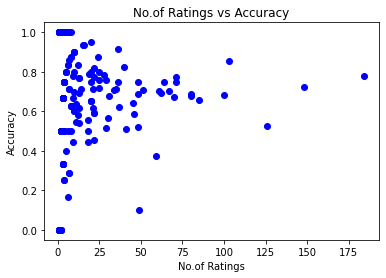

In [6]:
plot(rater_goodness['no_of_ratings'], rater_goodness['average_correctness'], marker='o',\
     color='blue', linestyle='None')
xlabel('No.of Ratings')
ylabel('Accuracy')
title('No.of Ratings vs Accuracy')
show()

Most of the turks are accumulated in the higher accuracy region and lower number of ratings. Those turks can be validadted as committed turks. The turks who have higher number of ratings also have accuracy higher than 0.5, so we can categorize them as committed.

## Q7. Overall predicted odds

In [7]:
reliable_turk_list = rater_goodness.sort_values(by = ['no_of_ratings'],ascending = False)\
[:round(0.25*len(rater_goodness))+1].index
# use quantile here
def reliable_turk_check(x):
    return x in reliable_turk_list

reliable_turks_labels = labels_unknown[labels_unknown['turk'].map(reliable_turk_check)]

reliable_turks_labels_merge = reliable_turks_labels.merge(rater_goodness, left_on = 'turk', right_on = 'turk')
predicted_odds = reliable_turks_labels_merge.groupby(['url','category'])['odds'].prod()
predicted_odds

url                          category
http://0-101.net             G            2.297602
http://000.cc                G            1.485456
http://0000.jp               G           14.339248
http://000relationships.com  G            6.704995
                             P            1.851852
                                           ...    
http://zynga.com             G            3.666513
http://zz868.com             G            1.047852
                             P            1.851852
http://zzx.cc                G            1.417620
                             X            1.620746
Name: odds, Length: 14114, dtype: float64

## Q8. Predicted categories

In [8]:
url_category_list = predicted_odds.unstack('category').fillna(0)
top_category = url_category_list.T.idxmax()
top_odds = url_category_list.T.apply(max)
result_75 = pd.concat({'top_category': top_category,
              'top_odds': top_odds},axis=1)
result_75

,top_category,top_odds
url,,
http://0-101.net,G,2.297602
http://000.cc,G,1.485456
http://0000.jp,G,14.339248
http://000relationships.com,G,6.704995
http://000vitamins.com,G,4.033641
...,...,...
http://zwinky.com,G,17.201875
http://zylom.com,G,1.849543
http://zynga.com,G,3.666513


In [9]:
#method 2 using quantiles
number_75 = rater_goodness['no_of_ratings'].quantile(0.75)
reliable_turks_75 = rater_goodness[rater_goodness['no_of_ratings'] > number_75].index

reliable_turks_labels_75 = labels_unknown[labels_unknown['turk'].isin(reliable_turks_75)]

reliable_turks_labels_merge_75 = reliable_turks_labels.merge(rater_goodness, left_on = 'turk', right_on = 'turk')
predicted_odds_75 = reliable_turks_labels_merge.groupby(['url','category'])['odds'].prod()
predicted_odds_75

url                          category
http://0-101.net             G            2.297602
http://000.cc                G            1.485456
http://0000.jp               G           14.339248
http://000relationships.com  G            6.704995
                             P            1.851852
                                           ...    
http://zynga.com             G            3.666513
http://zz868.com             G            1.047852
                             P            1.851852
http://zzx.cc                G            1.417620
                             X            1.620746
Name: odds, Length: 14114, dtype: float64

In [10]:
url_category_list_75 = predicted_odds_75.unstack('category').fillna(0)
top_category = url_category_list.T.idxmax()
top_odds = url_category_list.T.apply(max)
result_75_2 = pd.DataFrame(top_category, columns = ['top_category'])
result_75_2['top_odds'] = top_odds
result_75_2

,top_category,top_odds
url,,
http://0-101.net,G,2.297602
http://000.cc,G,1.485456
http://0000.jp,G,14.339248
http://000relationships.com,G,6.704995
http://000vitamins.com,G,4.033641
...,...,...
http://zwinky.com,G,17.201875
http://zylom.com,G,1.849543
http://zynga.com,G,3.666513


## Q9. Predicted categories using more turks

In [11]:
reliable_turk_list2 = rater_goodness.sort_values(by = ['no_of_ratings'],ascending = False)\
[:round(0.75*len(rater_goodness))].index

def reliable_turk_check2(x):
    return x in reliable_turk_list2

reliable_turks_labels2 = labels_unknown[labels_unknown['turk'].map(reliable_turk_check2)]

reliable_turks_labels_merge2 = reliable_turks_labels2.merge(rater_goodness, left_on = 'turk', right_on = 'turk')
predicted_odds2 = reliable_turks_labels_merge2.groupby(['url','category'])['odds'].prod()
predicted_odds2

url                          category
http://0-101.net             G           2.297602e+00
http://000.cc                G           2.218192e+03
                             P           9.980040e-01
http://0000.jp               G           2.847963e+07
http://000relationships.com  G           0.000000e+00
                                             ...     
http://zz868.com             G           1.209566e+16
                             P           1.851852e+00
http://zzx.cc                G           1.417620e+00
                             P           9.980040e-01
                             X           1.620746e+00
Name: odds, Length: 17044, dtype: float64

In [12]:
url_category_list2 = predicted_odds2.unstack('category').fillna(0)
top_category2 = url_category_list2.T.idxmax()
top_odds2 = url_category_list2.T.apply(max)
result_25 = pd.concat({'top_category': top_category2,
              'top_odds': top_odds2},axis=1)
# going to merge result_25 and result_75. There are some links which are not there in result_75. So default join,
# inner join won't have them

results_merge = pd.merge(result_25['top_category'], result_75['top_category'], left_index=True, right_index=True, suffixes = ['_25','_75'])
results_merge

,top_category_25,top_category_75
url,,
http://0-101.net,G,G
http://000.cc,G,G
http://0000.jp,G,G
http://000relationships.com,P,G
http://000vitamins.com,G,G
...,...,...
http://zwinky.com,P,G
http://zylom.com,G,G
http://zynga.com,G,G


In [13]:
results_merge['count'] = 1
#results_merge
results_merge.groupby(['top_category_25','top_category_75'])['count'].sum().unstack('top_category_25')

top_category_25,G,P,R,X
top_category_75,,,,
G,8115,698,196,220
P,223,321,61,21
R,24,34,126,26
X,50,9,34,452


In [14]:
#method 2 using quantiles
number_25 = rater_goodness['no_of_ratings'].quantile(0.25)
reliable_turks_25 = rater_goodness[rater_goodness['no_of_ratings'] > number_25].index

reliable_turks_labels_25 = labels_unknown[labels_unknown['turk'].isin(reliable_turks_25)]

reliable_turks_labels_merge_25 = reliable_turks_labels_25.merge(rater_goodness, left_on = 'turk', right_on = 'turk')
predicted_odds_25 = reliable_turks_labels_merge_25.groupby(['url','category'])['odds'].prod()
predicted_odds_25

url                          category
http://0-101.net             G           2.297602e+00
http://000.cc                G           2.218192e+03
                             P           9.980040e-01
http://0000.jp               G           2.847963e+07
http://000relationships.com  G           0.000000e+00
                                             ...     
http://zz868.com             G           1.209566e+16
                             P           1.851852e+00
http://zzx.cc                G           1.417620e+00
                             P           9.980040e-01
                             X           1.620746e+00
Name: odds, Length: 17794, dtype: float64

In [15]:
url_category_list_25 = predicted_odds_25.unstack('category').fillna(0)
top_category = url_category_list_25.T.idxmax()
top_odds = url_category_list_25.T.apply(max)
result_25_2 = pd.DataFrame(top_category, columns = ['top_category'])
result_25_2['top_odds'] = top_odds
result_25_2

,top_category,top_odds
url,,
http://0-101.net,G,2.297602e+00
http://000.cc,G,2.218192e+03
http://0000.jp,G,2.847963e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.343559e+03
...,...,...
http://zwinky.com,P,1.000000e+03
http://zylom.com,G,3.062113e+06
http://zynga.com,G,5.386158e+01


In [16]:
#results_merge_2 = pd.merge(result_25_2['top_category'], result_75_2['top_category'], left_index=True, right_index=True, suffixes = ['_25','_75'])

results_merge_2 = result_25_2.merge(result_75_2,left_index=True, right_index=True, suffixes = ['_25','_75'])
results_merge_2 = results_merge_2[['top_category_25','top_category_75']]
results_merge_2

,top_category_25,top_category_75
url,,
http://0-101.net,G,G
http://000.cc,G,G
http://0000.jp,G,G
http://000relationships.com,P,G
http://000vitamins.com,G,G
...,...,...
http://zwinky.com,P,G
http://zylom.com,G,G
http://zynga.com,G,G


In [17]:
results_merge_2['count'] = 1
#results_merge
results_merge_2.groupby(['top_category_25','top_category_75'])['count'].sum().unstack('top_category_25')

top_category_25,G,P,R,X
top_category_75,,,,
G,7882,829,280,238
P,238,285,71,32
R,23,35,118,34
X,69,11,36,429
